**Install required packages (if not already installed)**

In [1]:
# Install required packages (if not already installed)
!pip install torch torchvision torchaudio numpy matplotlib tensorflow
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.utils import to_categorical

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink-

**Step 1: Define a Base Model Class**

In [2]:
class BaseModel(nn.Module):
    def __init__(self):
        """Base class for all models, providing train and evaluate methods."""
        super().__init__()  # ✅ FIXED: Correct `super()` instantiation

    def train_model(self, X_train, y_train, X_test, y_test, epochs=100, lr=0.001, batch_size=32):
        """Train the model using mini-batch gradient descent."""
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)

        X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

        train_losses, test_losses = [], []

        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            self.train()
            epoch_loss = 0
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = self(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            scheduler.step()
            avg_train_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            # Evaluate Model
            self.eval()
            with torch.no_grad():
                test_outputs = self(X_test)
                test_loss = criterion(test_outputs, y_test)
                test_losses.append(test_loss.item())

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.6f}, Test Loss: {test_loss.item():.6f}")

        return train_losses, test_losses

    def evaluate_model(self, X_test, y_test):
        """Evaluate the model performance."""
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        X_test, y_test = X_test.to(device), y_test.to(device)

        self.eval()
        with torch.no_grad():
            y_pred = self(X_test).cpu().numpy()
        y_true = y_test.cpu().numpy()

        return {
            "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
            "MAE": mean_absolute_error(y_true, y_pred),
            "R²": r2_score(y_true, y_pred),
            "Predictions": y_pred
        }

**Step 2: Implement Specific Models**

Each model will inherit from BaseModel, making training and evaluation easier.

**MLP Implementation**

MLP consists of fixed activation functions on nodes and learnable weights on edges.

Below is a PyTorch implementation of MLP:


In [3]:
class MLP(BaseModel):
    def __init__(self, input_dim=49, hidden_dim=64, output_dim=49):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

**KAN Implementation**

KAN differs from MLP as it learns activation functions rather than keeping them fixed.

It learns activation functions on edges and applies a sum operation on nodes.

In [4]:
class KAN(BaseModel):
    def __init__(self, input_dim=49, hidden_dim=64, output_dim=49):
        super(KAN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.Parameter(torch.randn(hidden_dim))
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        return self.fc2(torch.sin(self.fc1(x) * self.activation))

**AQ-KAN Code Implementation (PyTorch)**

AQ-KAN extends KAN by incorporating quantum-inspired mechanisms such as Hadamard transformations, entanglement, and superposition, making it adaptive and more expressive than standard KAN.

🔹 **Key Features of AQ-KAN**

Quantum-Inspired Cells: Uses Hadamard Transform to create superpositions and Pauli-X Transform to manipulate quantum states.

Adaptive Activation Functions: Unlike KAN, it allows dynamic transformation of activations based on input.

Entanglement Mechanism: Certain neurons (grid-based cells) are entangled, affecting each other’s transformations.

Kolmogorov-Arnold Representation: Like KAN, it follows a functional composition approach but learns the functions in an adaptive manner.


In [5]:
class QuantumInspiredCell:
    """Represents a single cell in the adaptive quantum grid with quantum-inspired transformations."""

    def __init__(self, position, initial_amplitude=1.0):
        self.position = position
        self.amplitude = initial_amplitude  # |ψ|^2 represents probability
        self.entangled_neighbors = []
        self.state = np.array([initial_amplitude, 1 - initial_amplitude])  # |0> and |1>

    def hadamard_transform(self):
        """Applies Hadamard gate to create superposition."""
        H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
        self.state = np.dot(H, self.state)

    def pauli_x_transform(self):
        """Applies Pauli-X gate to flip quantum state."""
        X = np.array([[0, 1], [1, 0]])
        self.state = np.dot(X, self.state)

    def update_state(self, input_signal):
        """Dynamically update quantum-inspired state based on input properties."""
        weight = np.tanh(input_signal)  # Modulation function
        self.state = self.state * weight
        self.state /= np.linalg.norm(self.state)  # Normalize state

    def entangle_with(self, neighbor_cell, weight=0.5):
        """Creates an entanglement relationship between this cell and a neighbor."""
        self.entangled_neighbors.append((neighbor_cell, weight))

class AQKAN(BaseModel):
    """Adaptive Quantum-Inspired Kolmogorov-Arnold Network"""

    def __init__(self, input_dim, hidden_dim, output_dim, grid_size=(4, 4)):
        super(AQKAN, self).__init__()
        self.grid_size = grid_size
        self.grid = [[QuantumInspiredCell((i, j)) for j in range(grid_size[1])] for i in range(grid_size[0])]
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.q_transform = nn.Parameter(torch.randn(hidden_dim))  # Quantum-inspired transform
        self.hadamard = nn.Linear(hidden_dim, hidden_dim)  # Simulated Hadamard gate
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.Tanh()

    def initialize_superposition(self):
        """Initialize the entire grid in superposition state."""
        for row in self.grid:
            for cell in row:
                cell.hadamard_transform()

    def apply_entanglement(self):
        """Entangle each cell with its neighboring cells dynamically."""
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                cell = self.grid[i][j]
                if i > 0:
                    cell.entangle_with(self.grid[i-1][j])
                if j > 0:
                    cell.entangle_with(self.grid[i][j-1])
                if i < self.grid_size[0] - 1:
                    cell.entangle_with(self.grid[i+1][j])
                if j < self.grid_size[1] - 1:
                    cell.entangle_with(self.grid[i][j+1])

    def update_states(self, input_data):
        """Update grid states dynamically based on input data."""
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                self.grid[i][j].update_state(input_data[i, j])

    def measure_states(self):
        """Collapse quantum states into classical values."""
        measurement_results = np.zeros(self.grid_size)
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                measurement_results[i, j] = np.argmax(self.grid[i][j].state)  # Collapse state
        return measurement_results

    def forward(self, x):
        """Feedforward process with quantum-inspired transformations."""
        x = self.fc1(x)
        x = torch.sin(x * self.q_transform)  # Quantum-Inspired Activation
        x = self.hadamard(x)  # Simulated Hadamard Transformation
        x = self.activation(x)  # Adaptive transformation
        x = self.fc2(x)
        return x

**BiLSTM (Bidirectional LSTM) Implementation**

A BiLSTM (Bidirectional Long Short-Term Memory) network learns dependencies from both past and future data.


In [6]:
class BiLSTMModel(BaseModel):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=49):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        x, _ = self.lstm(x)
        return self.fc(x[:, -1, :])

**Bayesian Neural Network (BNN) Implementation**

A Bayesian Neural Network (BNN) introduces uncertainty estimation by treating weights as distributions instead of fixed values.


In [7]:
class BayesianNN(BaseModel):
    def __init__(self, input_dim=49, hidden_dim=64, output_dim=49):
        super(BayesianNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x)))

**Transformer Model Implementation**

The Transformer model captures long-range dependencies using self-attention instead of recurrence.

In [8]:
class TransformerModel(BaseModel):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=49, nhead=8, num_layers=2):
        super(TransformerModel, self).__init__()

        # ✅ Ensure hidden_dim % nhead == 0 to avoid assertion errors
        assert hidden_dim % nhead == 0, "hidden_dim must be divisible by nhead"

        # ✅ Embedding layer to project input_dim (1) to hidden_dim (64)
        self.embedding = nn.Linear(input_dim, hidden_dim)

        # ✅ Positional Encoding to retain sequence order
        self.positional_encoding = nn.Parameter(torch.randn(1, hidden_dim))

        # ✅ Transformer Encoder
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        # ✅ Fully connected output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """Forward pass through embedding, positional encoding, Transformer, and output layer."""
        x = self.embedding(x)  # ✅ Embed input from (batch, seq_len, 1) → (batch, seq_len, hidden_dim)
        x += self.positional_encoding  # ✅ Add positional information
        x = self.transformer_encoder(x)  # ✅ Process through Transformer
        return self.fc(x)  # ✅ Output layer

**1. Function Approximation & Regression with Deep Learning**

We'll use MLP, KAN, AQ-KAN, Transformer, BiLSTM, and Bayesian NN to test their ability to approximate sine waves.

🔹 Goal: Test the network’s ability to approximate complex functions.

🔹 Steps:

✅ Generate Synthetic Sine Wave Data

✅ Define Deep Learning Models (MLP, KAN, AQ-KAN, Transformer, BiLSTM, Bayesian NN)

✅ Train & Evaluate Models (Loss, RMSE, MAE, R² Score)

✅ Compare Predictions (Actual vs. Predicted Sine Waves)

Training MLP...
Epoch 0, Train Loss: 0.414393, Test Loss: 0.298240
Epoch 10, Train Loss: 0.000499, Test Loss: 0.000503
Epoch 20, Train Loss: 0.000294, Test Loss: 0.000296
Epoch 30, Train Loss: 0.000203, Test Loss: 0.000202
Epoch 40, Train Loss: 0.000149, Test Loss: 0.000150
Epoch 50, Train Loss: 0.000117, Test Loss: 0.000119
Epoch 60, Train Loss: 0.000094, Test Loss: 0.000098
Epoch 70, Train Loss: 0.000078, Test Loss: 0.000081
Epoch 80, Train Loss: 0.000065, Test Loss: 0.000067
Epoch 90, Train Loss: 0.000055, Test Loss: 0.000056
Training KAN...
Epoch 0, Train Loss: 0.407907, Test Loss: 0.251179
Epoch 10, Train Loss: 0.000565, Test Loss: 0.000505
Epoch 20, Train Loss: 0.000168, Test Loss: 0.000163
Epoch 30, Train Loss: 0.000090, Test Loss: 0.000088
Epoch 40, Train Loss: 0.000055, Test Loss: 0.000054
Epoch 50, Train Loss: 0.000036, Test Loss: 0.000035
Epoch 60, Train Loss: 0.000025, Test Loss: 0.000024
Epoch 70, Train Loss: 0.000017, Test Loss: 0.000017
Epoch 80, Train Loss: 0.000012, Te

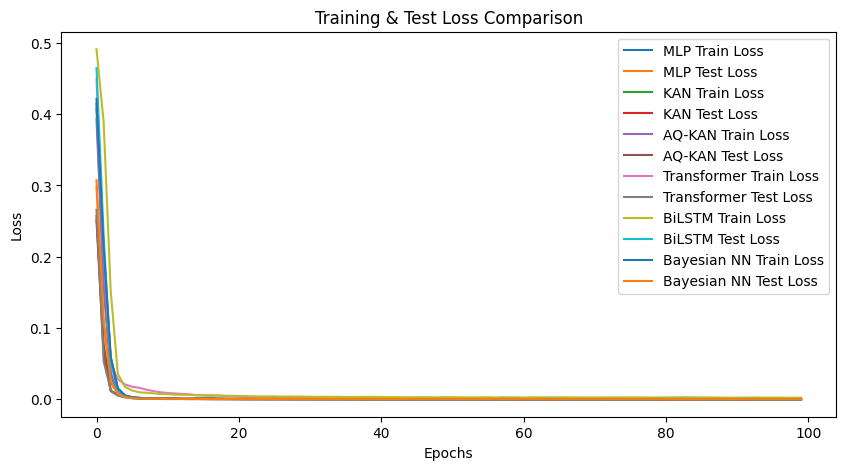

In [27]:
# 🎯 Import Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader  # ✅ FIXED: Import Missing Modules
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 🎯 Base Model for Training & Evaluation
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()

    def train_model(self, X_train, y_train, X_test, y_test, epochs=100, lr=0.001, batch_size=64):
        """Train the model with batch processing and gradient clipping for stability."""

        # ✅ Define loss function & optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        train_losses, test_losses = [], []

        # ✅ Use DataLoader for batch processing
        train_dataset = TensorDataset(X_train, y_train)  # ✅ FIXED: Now TensorDataset is defined
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            self.train()
            epoch_loss = 0

            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = self(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)  # ✅ Apply gradient clipping
                optimizer.step()
                epoch_loss += loss.item()

            train_losses.append(epoch_loss / len(train_loader))

            # ✅ Compute test loss
            self.eval()
            with torch.no_grad():
                test_outputs = self(X_test)
                test_loss = criterion(test_outputs, y_test)
                test_losses.append(test_loss.item())

            # ✅ Print loss every 10 epochs
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_losses[-1]:.6f}, Test Loss: {test_losses[-1]:.6f}")

        return train_losses, test_losses # ✅ RETURN NOW INSIDE THE FUNCTION

    def evaluate_model(self, X_test, y_test):
        """Evaluate model performance."""
        self.eval()
        with torch.no_grad():
            y_pred = self(X_test).cpu().numpy()  # Ensure conversion from GPU if necessary
        y_true = y_test.cpu().numpy()  # Ensure target is also converted

        return {
            "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
            "MAE": mean_absolute_error(y_true, y_pred),
            "R²": r2_score(y_true, y_pred),
            "Predictions": y_pred,
        }

# 🎯 Define Model Architectures
class MLP(BaseModel):
    def __init__(self, input_dim=49, hidden_dim=64, output_dim=49):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

class KAN(BaseModel):
    def __init__(self, input_dim=49, hidden_dim=64, output_dim=49):
        super(KAN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.Parameter(torch.randn(hidden_dim))  # Learnable activation
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        return self.fc2(torch.sin(self.fc1(x) * self.activation))

class AQKAN(BaseModel):
    def __init__(self, input_dim=49, hidden_dim=64, output_dim=49):
        super(AQKAN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.q_transform = nn.Parameter(torch.randn(hidden_dim))  # Quantum-inspired transform
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.sin(self.fc1(x) * self.q_transform)  # Quantum-inspired activation
        return self.fc2(torch.tanh(x))  # Additional transformation

class TransformerModel(BaseModel):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=49, nhead=8, num_layers=2, seq_len=49):
        super(TransformerModel, self).__init__()
        assert hidden_dim % nhead == 0, "hidden_dim must be divisible by nhead"

        self.seq_len = seq_len  # ✅ Ensure sequence length matches input
        self.embedding = nn.Linear(input_dim, hidden_dim)  # ✅ Convert input_dim=1 to hidden_dim
        self.positional_encoding = nn.Parameter(torch.randn(1, self.seq_len, hidden_dim))  # ✅ Fix shape

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, output_dim)  # ✅ Map hidden_dim to output_dim

    def forward(self, x):
        x = self.embedding(x)  # ✅ Embed input
        x = x + self.positional_encoding[:, :x.shape[1], :]  # ✅ Match input sequence length
        x = self.transformer_encoder(x)  # Transformer encodes input sequence
        x = x[:, -1, :]  # ✅ Take the last time-step embedding for final output
        return self.fc(x)  # ✅ Map to output_dim

class BiLSTMModel(BaseModel):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=49, num_layers=2, dropout=0.2):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # BiLSTM has 2x hidden_dim due to bidirectionality
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])  # Take last time-step and apply dropout
        return self.fc(x)

class BayesianNN(BaseModel):
    def __init__(self, input_dim=49, hidden_dim=64, output_dim=49):
        super(BayesianNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x)))

# 🎯 Model Initialization
models = {
    "MLP": MLP(),
    "KAN": KAN(),
    "AQ-KAN": AQKAN(),
    "Transformer": TransformerModel(input_dim=1),
    "BiLSTM": BiLSTMModel(input_dim=1),
    "Bayesian NN": BayesianNN(),
}

# 🚀 Train & Evaluate Models
train_losses, test_losses, model_metrics = {}, {}, {}
for name, model in models.items():
    print(f"Training {name}...")
    X_train_input, X_test_input = (X_train.unsqueeze(2), X_test.unsqueeze(2)) if name in ["BiLSTM", "Transformer"] else (X_train, X_test)
    train_losses[name], test_losses[name] = model.train_model(X_train_input, y_train, X_test_input, y_test)
    model_metrics[name] = model.evaluate_model(X_test_input, y_test)

# 🎯 Print Validation Metrics
for name, metrics in model_metrics.items():
    print(f"\n{name} Performance:")
    print(f"RMSE: {metrics['RMSE']:.4f}, MAE: {metrics['MAE']:.4f}, R² Score: {metrics['R²']:.4f}")

# 🎯 Plot Loss Curves
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
for name in models.keys():
    plt.plot(train_losses[name], label=f"{name} Train Loss")
    plt.plot(test_losses[name], label=f"{name} Test Loss")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Test Loss Comparison")
plt.show()